In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
from glob import glob
from scipy.io import loadmat
from PIL import Image
import matplotlib.pyplot as plt

In [6]:
from tensorboardX import SummaryWriter

In [7]:
IMG_DIR = 'data/flower_data/images/*'
LBL_DIR = 'data/flower_data/imagelabels.mat'

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 10
num_classes = 102
batch_size = 16
learning_rate = 0.001

# Tensorboard
writer = SummaryWriter()

class OxfordPetsDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.pets_df = train_df = pd.read_csv(csv_path, sep=' ', names = ["Image", "ID", "Species", "Breed"])
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return len(self.pets_df)
    def __getitem__(self, idx):
        img_name = self.img_dir + self.pets_df.iloc[idx, 0] + '.jpg'
        image = Image.open(img_name).convert('RGB')
        label = self.pets_df.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
            
        return (image, label)
### Download Images and Labels from
[Visual Geometrey Group Website](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/)

In [8]:
class Flowers102_Dataset(Dataset):
    def __init__(self, img_dir, lbl_dir, transform=None):
        self.img_glob = sorted(glob(img_dir))
        self.labels = loadmat(LBL_DIR)['labels'].squeeze()
        self.transform = transform
        self.classes = 'hi'
    def __len__(self):
        return len(self.img_glob)
    def __getitem__(self, idx):
        image = Image.open(self.img_glob[idx])
        # Classes must be zero indexed
        label = self.labels[idx]-1
        
        if self.transform:
            image = self.transform(image)
        return (image, label)

data_transform = transforms.Compose([
                 transforms.Resize(256),
                 transforms.CenterCrop(224),
                 transforms.ToTensor(),
                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

flower_dataset = Flowers102_Dataset(IMG_DIR, LBL_DIR, data_transform)
train_size = int(0.95*len(flower_dataset))
test_size = len(flower_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(flower_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=4)

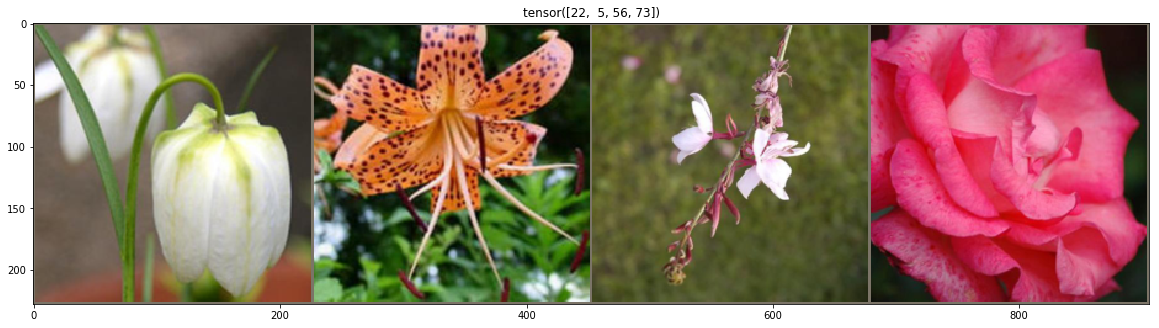

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    # Convert from tensor to PIL image
    inp = inp.numpy().transpose((1, 2, 0))
    # Unnormalize image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, str(classes))

In [10]:
# Load Pretrained Network and Freeze Layers except final classifer layers
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
resnet18 = torchvision.models.resnet18(pretrained=True)
set_parameter_requires_grad(resnet18, True)
resnet18.fc = nn.Linear(512, num_classes)
resnet18 = resnet18.to(device)

In [11]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=learning_rate)

In [12]:
def train(data_loader, model, criterion, optimizer, epoch, train_step, device):
    model.train()
    for i, (images, labels) in enumerate(data_loader):
        # Move
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward Pass
        output = model(images)
        loss = criterion(output, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], Loss: {loss.item():.4f}")
            writer.add_scalar('Train/Training Loss', loss.item(), train_step)
        train_step +=1
        
    return train_step

def test(data_loader, model, criterion, test_step, device):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            
            # Accuracy Measurement
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            acc =  (predicted == labels).sum().item() / labels.size(0)
            test_step +=1
                
        total_acc = correct /total
        print(f'Test Accuracy of the model on the test images: {total_acc}')
        writer.add_scalar('Test/Accuracy', total_acc, test_step)
        
        return test_step

In [ ]:
# Train and Test SqueezeNet
train_step = 0
test_step = 0
for epoch in range(num_epochs):
    train_step = train(train_loader, resnet18, criterion, optimizer, epoch, train_step, device)
    test_step = test(test_loader, resnet18, criterion, test_step, device)

Epoch [1/10], Step [100/1945], Loss: 3.6950
Epoch [1/10], Step [200/1945], Loss: 4.1232
Epoch [1/10], Step [300/1945], Loss: 4.4761
Epoch [1/10], Step [400/1945], Loss: 3.4101
Epoch [1/10], Step [500/1945], Loss: 1.1129
Epoch [1/10], Step [600/1945], Loss: 2.3376
Epoch [1/10], Step [700/1945], Loss: 2.4190
Epoch [1/10], Step [800/1945], Loss: 2.8175
Epoch [1/10], Step [900/1945], Loss: 2.6953
Epoch [1/10], Step [1000/1945], Loss: 1.7041
Epoch [1/10], Step [1100/1945], Loss: 2.1961
Epoch [1/10], Step [1200/1945], Loss: 2.1047
Epoch [1/10], Step [1300/1945], Loss: 4.4953
Epoch [1/10], Step [1400/1945], Loss: 1.4038
Epoch [1/10], Step [1500/1945], Loss: 1.1473
Epoch [1/10], Step [1600/1945], Loss: 2.3742
Epoch [1/10], Step [1700/1945], Loss: 1.0791
Epoch [1/10], Step [1800/1945], Loss: 0.8596
Epoch [1/10], Step [1900/1945], Loss: 0.2042
Test Accuracy of the model on the test images: 0.8
Epoch [2/10], Step [100/1945], Loss: 0.9711
Epoch [2/10], Step [200/1945], Loss: 1.0428
Epoch [2/10], S